In [1]:
import sys
# Define relative path.
sys.path.append("python")

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampling_trajectory import morris_trajectory
from screening_measures_gm_2017 import screening_measures_gm_2017

from transform_reorder import reorder_cov
from transform_distributions import covariance_to_correlation
import scipy.linalg as linalg

In [3]:
"""Perhaps I need to add the scaled Elementary Effects (by SD)"""

'Perhaps I need to add the scaled Elementary Effects (by SD)'

In [4]:
def bar_plot(input_par_array):
    new_list = input_par_array.reshape(-1, 1).tolist()
    merged = pd.Series(itertools.chain.from_iterable(new_list))
    vc = merged.value_counts().sort_index()
    vc /= float(vc.sum())
    assert vc.sum() > 0.999
    ax = vc.plot(kind='bar')
    fig = ax.get_figure()
    fig.autofmt_xdate()

In [5]:
seed = 2020
n_levels = 10
n_inputs = 3
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

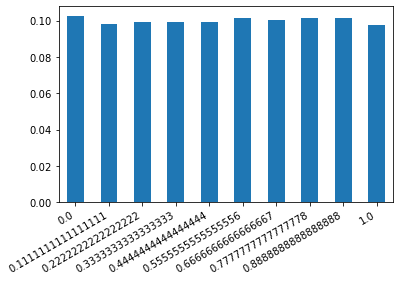

In [6]:
"Check: For some even n_levels 1.0 has double the number of observations."
bar_plot(np.vstack(sample_traj_list))

In [7]:
expectation = np.array([0, 0, 0])
"""
cov = np.array(
    [
        [1.0, 0.5, 0.0],
        [0.5, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)
"""
cov = np.array(
    [
        [1.0, 0.9, 0.4],
        [0.9, 1.0, 0.0],
        [0.4, 0.0, 1.0],
    ]
)

In [8]:
def linear_function(a, b, c, *args):
    return a + b + c

In [9]:
"""I am able to replicate the results for the two normally distributed examples. The only difference is the scale because they seem to use another number of levels."""
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linear_function, sample_traj_list, cov, n_levels, mu=expectation)

In [10]:
"""
In my opinion, we would like to have the values for `abs_ee_ind` and `sd_ee_ind` to be equal.
However, the independet measures for dependent inputs are always smaller than the ones for the independent inputs because the positive delta gets decorrelated (decreases) for the former type.
In 2d case: delta/np.sqrt(1-rho^2). This actually re-introduces dependancies. This should not happen for an independet EE.

My proposal for improvement: Add delta after decorrrlating the sample for the independent effect.
Question: Why do the Sobol' indices follow this trend without a fixed delta? Probably they also decorrelate the squared distance between observation and mean.
"""
abs_ee_ind

array([[0.60883039],
       [0.66527699],
       [1.39625905]])

In [11]:
sd_ee_ind

array([[0.62263717],
       [0.68059779],
       [1.42841459]])

In [12]:
abs_ee_full

array([[8.08469294],
       [6.68859836],
       [4.91937816]])

In [13]:
sd_ee_full

array([[8.26803391],
       [6.84263143],
       [5.03267038]])

In [14]:
"""Ishigami"""
def ishigami(q0, q1, q2, a=2, b=3):
    """Note: Originally, this function takes uniform, not standard normally distributed inputs"""
    return np.sin(q0) + a*(np.sin(q1))**2 + b*q2**4*np.sin(q0)

In [15]:
cov = np.array(
    [
        [1.0, 0.5, 0.0],
        [0.5, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)

In [16]:
a=2
b=3
vals = [0.5 + (a**2)/8 + (b*(np.pi**4))/5 + ((b**2)*(np.pi**8)/18),
        (0.5 + b*(np.pi**4)/5 + (b**2)*(np.pi**8)/50), (a**2)/8,
         0, 0, (8*b**2*np.pi**8)/225, 0, 0]
total_order = [(vals[1]+vals[5])/vals[0], vals[2]/vals[0], vals[5]/vals[0]]

In [17]:
total_order # Compare with sd_ee_ind.

[0.9998959138041636, 0.00010408619583630811, 0.6320800624240672]

In [18]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(ishigami, sample_traj_list, cov, n_levels, mu=expectation)

In [19]:
abs_ee_ind

array([[36.74671064],
       [ 2.12252248],
       [39.4414288 ]])

In [20]:
sd_ee_ind

array([[78.79884993],
       [ 2.36653368],
       [64.55201645]])

In [21]:
abs_ee_full

array([[42.58839549],
       [23.34094679],
       [39.4414288 ]])

In [22]:
sd_ee_full

array([[85.98099457],
       [50.53043426],
       [64.55201645]])

In [23]:
"""
new experiment, see on page 15 in
http://www2.stat.duke.edu/~fei/samsi/Readings/06LinkBingHengHigfYe.pdf

"""
seed = 2020
n_levels = 10
n_inputs = 8
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

In [24]:
def linkletter_et_al_2006(x0, x1, x2, x3, x4, x5, x6, x7, *args):
    epsilon = np.random.normal(0, 0.05)
    return 0.2*x0 + (0.2/2)*x1 + (0.2/4)*x2 + (0.2/8)*x3 + (0.2/16)*x4 + (0.2/32)*x5 + (0.2/64)*x6 + (0.2/128)*x7 + epsilon

In [25]:
expectation = np.array([0, 0, 0, 0, 0, 0, 0, 0])


cov = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    ]
)

In [26]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linkletter_et_al_2006, sample_traj_list, cov, n_levels, mu=expectation)

In [27]:
abs_ee_ind

array([[0.70165289],
       [0.35347313],
       [0.18673007],
       [0.12439196],
       [0.10800479],
       [0.10270555],
       [0.1006008 ],
       [0.10084491]])

In [28]:
sd_ee_ind

array([[0.72849798],
       [0.38311621],
       [0.21965497],
       [0.15466003],
       [0.13554984],
       [0.1288121 ],
       [0.12619464],
       [0.12635073]])

In [29]:
abs_ee_full

array([[0.70484402],
       [0.35244601],
       [0.18780848],
       [0.12600586],
       [0.10775993],
       [0.10285872],
       [0.10263554],
       [0.10091443]])

In [30]:
sd_ee_full

array([[0.73214743],
       [0.38227639],
       [0.22075352],
       [0.15651347],
       [0.135768  ],
       [0.12898606],
       [0.12815038],
       [0.12647607]])